In [56]:
from numpy import mean
from pandas import Series
from sklearn.base import RegressorMixin


class RollingMeanRegressor(RegressorMixin):
    def __init__(self, win: int = 3):
        super().__init__()
        self.win_size = win
        self.memory: list = []

    def fit(self, X: Series):
        self.memory = X.iloc[-self.win_size :]
        # print(self.memory)
        return
    
    def predict(self, X: Series):
        estimations = self.memory.tolist()
        for i in range(len(X)):
            new_value = mean(estimations[-self.win_size:])  # Fix the slicing here
            estimations.append(new_value)
        prd_series: Series = Series(estimations[-len(X):])  # Use only the last len(X) values
        if len(prd_series) != len(X):
            raise ValueError("Predicted series length does not match input series length.")
        prd_series.index = X.index  # Match the index
        return prd_series


In [57]:
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_line_chart


def rolling_mean_study(train: Series, test: Series, measure: str = "R2"):
    # win_size = (3, 5, 10, 15, 20, 25, 30, 40, 50)
    win_size = (12, 24, 48, 96, 192, 384, 768)
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Rolling Mean", "metric": measure, "params": ()}
    best_performance: float = -100000

    yvalues = []
    for w in win_size:
        pred = RollingMeanRegressor(win=w)
        pred.fit(train)
        prd_tst = pred.predict(test)

        eval: float = FORECAST_MEASURES[measure](test, prd_tst)
        # print(w, eval)
        if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (w,)
            best_model = pred
        yvalues.append(eval)

    print(f"Rolling Mean best with win={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    plot_line_chart(
        win_size, yvalues, title=f"Rolling Mean ({measure})", xlabel="window size", ylabel=measure, percentage=flag
    )

    return best_model, best_params

Rolling Mean best with win=24 -> R2=0.01341384681159219


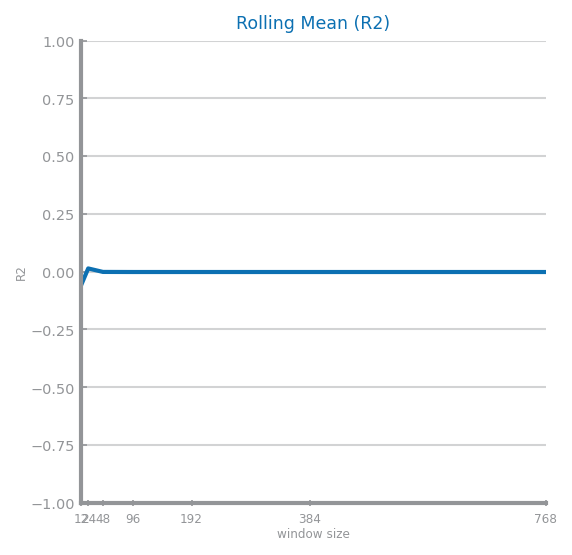

In [ ]:
from pandas import read_csv, DataFrame
from matplotlib.pyplot import figure, savefig
from dslabs_functions import series_train_test_split, plot_forecasting_eval, plot_forecasting_series, HEIGHT

filename: str = "/home/mina/Documents/portugal/dataScience/set_1_diff_twice.csv"
file_tag: str = "Set 1"
target: str = "Manhattan"
timecol: str = "Date"
measure: str = "RMSE"

data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series: Series = data[target]

train, test = series_train_test_split(data, trn_pct=0.90)

fig = figure(figsize=(HEIGHT, HEIGHT))
best_model, best_params = rolling_mean_study(train, test)
savefig(f"/home/mina/Documents/portugal/dataScience/Data_science_project/MODELS’ EVALUATION/images_rolling/{file_tag}_rollingmean_{measure}_study.png")

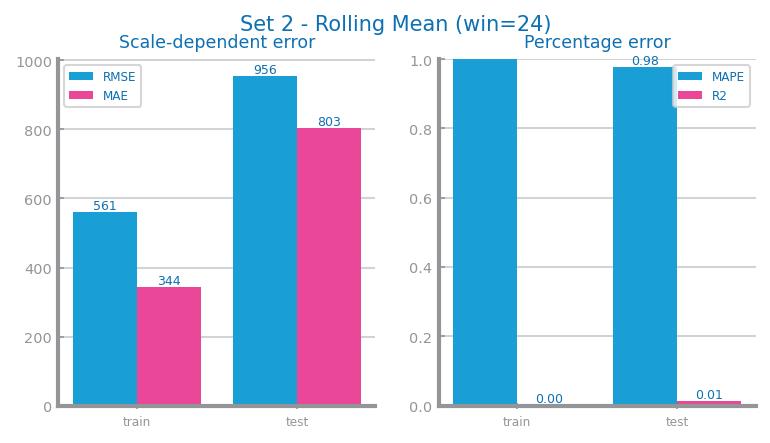

In [59]:
params = best_params["params"]
prd_trn: Series = best_model.predict(train)
prd_tst: Series = best_model.predict(test)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Rolling Mean (win={params[0]})")
savefig(f"/home/mina/Documents/portugal/dataScience/Data_science_project/MODELS’ EVALUATION/images_rolling/{file_tag}_rollingmean_{measure}_win{params[0]}_eval.png")

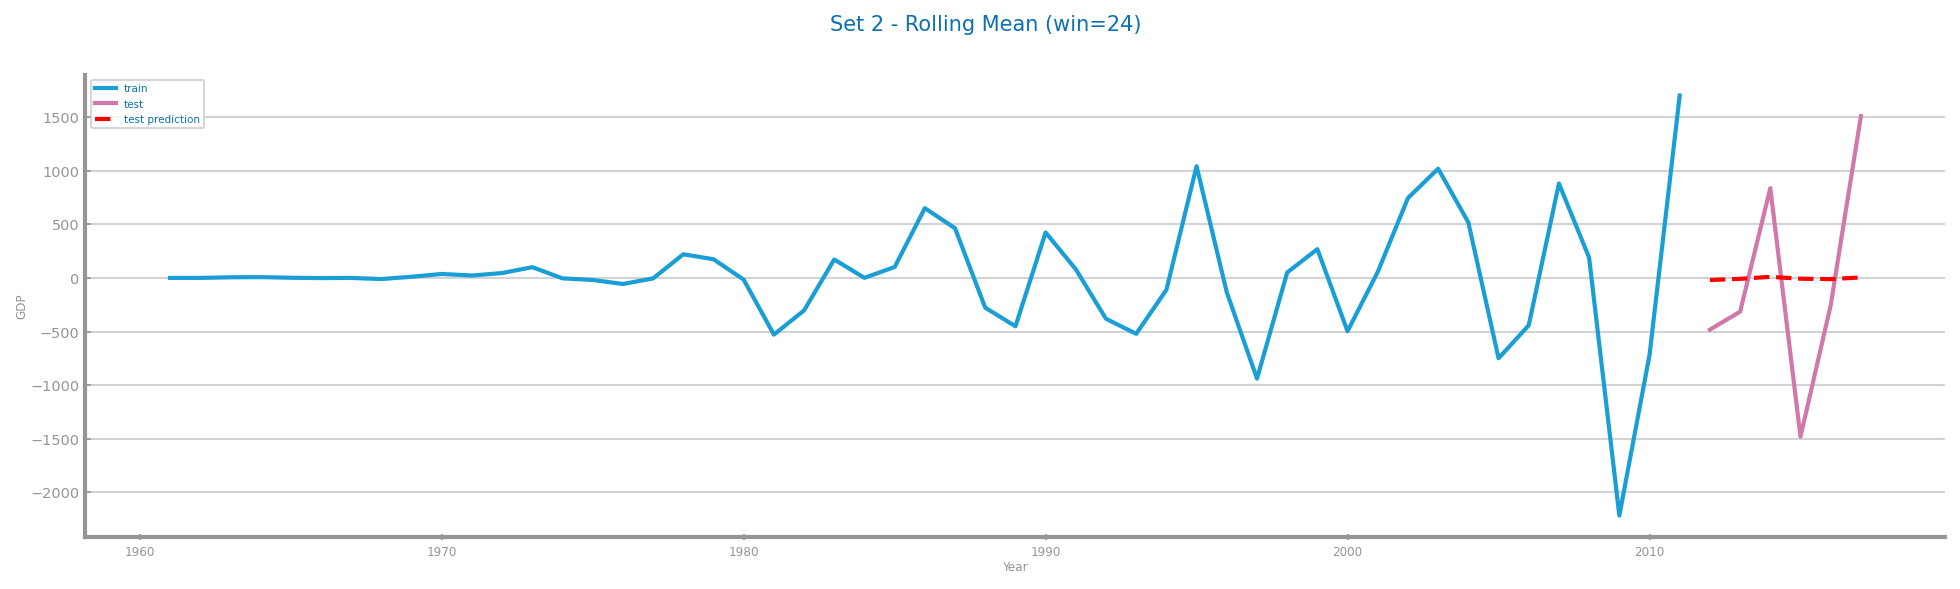

In [60]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Rolling Mean (win={params[0]})",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"/home/mina/Documents/portugal/dataScience/Data_science_project/MODELS’ EVALUATION/images_rolling/{file_tag}_rollingmean_{measure}_forecast.png")
